In [ ]:
## Requirements : 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from osgeo import gdal
import sys
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torchvision import datasets, transforms
import helper
from __future__ import print_function, division
import natsort 
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [ ]:
## read cropped image as Array : 

def npy_to_matrix(path): 
 # print(path)
  with open(path, 'rb') as f:
    data = np.load(f)
  return data

In [ ]:
## read tif image as Array : 

def tif_to_matrix(path):
  print(path)
  src_ds = gdal.Open(path)
  data = src_ds.ReadAsArray()
  return data 

In [ ]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [ ]:
## Create a Customized dataset class for Pytorch : 

class CustomDataSet(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        
    def __len__(self):
        return len(self.landmarks_frame)
        

    def __getitem__(self, idx):

      if torch.is_tensor(idx):
        idx = idx.tolist()

      img_name = self.landmarks_frame.iloc[idx, -1]
      img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 6])
      #image = tif_to_matrix(img_name) ## for non cropped images
      #print(img_name)
      image = npy_to_matrix(img_name).astype(float)
      soilreadings = self.landmarks_frame.iloc[idx, 4]
      
      soilreadings = np.array(soilreadings).astype(float)
 
      sample = {'image': image, 'soilreadings': soilreadings}
      #print(sample['image'].shape)
      #sample = {'image': img_name, 'soilreadings': soilreadings}
      if self.transform:
          sample = self.transform(sample)

      return sample

In [ ]:
## Read my dataset : 

#soil_dataset = CustomDataSet(csv_file='/content/Whole_dataset2.csv',root_dir='/content/drive/MyDrive/Zakarya/test/')
soil_dataset = CustomDataSet(csv_file='/content/drive/MyDrive/Zakarya/datasets/Cropped_dataset.csv', root_dir='/content/drive/MyDrive/Zakarya/dump_test/')

In [ ]:
## Transofrm functions : 

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, soilreadings = sample['image'], sample['soilreadings']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for soilreadings because for images,
        # x and y axes are axis 1 and 0 respectively
        soilreadings = soilreadings * [new_w / w, new_h / h]

        return {'image': img, 'soilreadings': soilreadings}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, soilreadings = sample['image'], sample['soilreadings']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        soilreadings = soilreadings - [left, top]

        return {'image': image, 'soilreadings': soilreadings}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, soilreadings = sample['image'], sample['soilreadings']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'soilreadings': torch.from_numpy(soilreadings)}

In [ ]:
## Defind the parameters : 

scale = Rescale(128)
crop = RandomCrop(64)
composed = transforms.Compose([Rescale(128),
                               RandomCrop(64)])

In [ ]:
## Read the Customized dataset as tensors :

transformed_dataset = CustomDataSet(csv_file='/content/drive/MyDrive/Zakarya/datasets/Cropped_dataset.csv', 
                                    root_dir='/content/drive/MyDrive/Zakarya/dump_test/',
                                           transform=transforms.Compose([ToTensor()]))

In [ ]:
## Split the dataloader to train and validation loaders :

batch_size = 4
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(transformed_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,drop_last=True , 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,drop_last=True ,
                                                sampler=valid_sampler)

In [ ]:
## Switch the work to the GPU : 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
## Model Architecture : 

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3)
        self.conv2 = nn.Conv2d(12, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        
        self.fc1 = nn.Linear(633680, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.softmax(self.fc1(x))
      
        return x

In [ ]:
## Model to GPU :

model = CNN()
model = CNN().to(device)

In [ ]:
## Running time parameters : 

epochs = 30
num_epochs = 30
batch_size = 5
learning_rate = 0.001

In [ ]:
## Loss Function : 

def rmseLoss(output, target):
  loss_fn = nn.MSELoss()
  a = torch.sqrt(loss_fn(output.float(), target.float()))
  return a.float() 
criterion=rmseLoss

In [ ]:
## Optimizer : 

optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
## Train the Model : 

%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in enumerate(train_loader):
        # move-tensors-to-GPU 
        #print(target)
        data = target['image']
        target = target['soilreadings']
        data = normalize(data)
        data = data.float()
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        optimizer.zero_grad()
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in enumerate(validation_loader):
        data = target['image']
        target = target['soilreadings']
        data = normalize(data)      
        data = data.float()
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        data.size()
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.651130 	Validation Loss: 0.628872
Epoch: 2 	Training Loss: 0.649943 	Validation Loss: 0.611264
Epoch: 3 	Training Loss: 0.656251 	Validation Loss: 0.605208
Epoch: 4 	Training Loss: 0.647590 	Validation Loss: 0.602670
Epoch: 5 	Training Loss: 0.652666 	Validation Loss: 0.625159
Epoch: 6 	Training Loss: 0.654963 	Validation Loss: 0.605079
Epoch: 7 	Training Loss: 0.659500 	Validation Loss: 0.606347
Epoch: 8 	Training Loss: 0.651029 	Validation Loss: 0.610196
Epoch: 9 	Training Loss: 0.649373 	Validation Loss: 0.606966
Epoch: 10 	Training Loss: 0.654858 	Validation Loss: 0.627348
Epoch: 11 	Training Loss: 0.649938 	Validation Loss: 0.620804
Epoch: 12 	Training Loss: 0.651799 	Validation Loss: 0.626328
Epoch: 13 	Training Loss: 0.655504 	Validation Loss: 0.605884
Epoch: 14 	Training Loss: 0.652441 	Validation Loss: 0.626460
Epoch: 15 	Training Loss: 0.656862 	Validation Loss: 0.612553
Epoch: 16 	Training Loss: 0.648885 	Validation Loss: 0.608208
Epoch: 17 	Traini

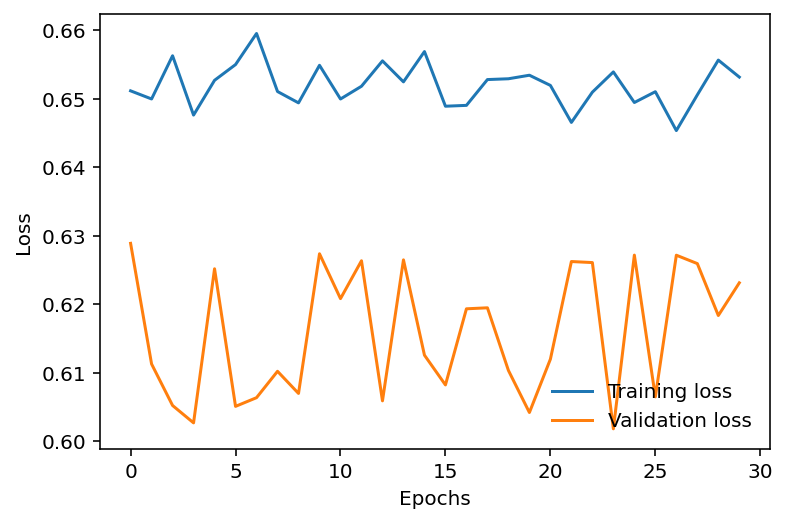

In [ ]:
## Visualize the Train & validation losses :
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)